# Employee Performance and Retention Analysis

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score, classification_report
import tensorflow as tf
from tensorflow import keras

# Phase 1 – Data Collection & EDA

# Step 1 - Load and Preprocess Dataset

In [5]:
# Load dataset
df = pd.read_csv("../data+science/employee_data.csv")

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Clean inconsistent data (strip spaces, standardize case for strings)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip().str.title()

# Display first 5 rows
df.head()


,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition
0,1,John Doe,29,Sales,55000,3,80,No
1,2,Jane Smith,35,Hr,60000,7,85,No
2,3,Michael Brown,40,Engineering,80000,10,95,Yes
3,4,Emily Davis,28,Marketing,65000,5,78,No
4,5,David Johnson,50,Sales,75000,20,88,Yes


# Step 2 - Exploratory Data Analysis (EDA)

       EmployeeID         Age        Salary  YearsAtCompany  PerformanceScore
count  100.000000  100.000000    100.000000      100.000000        100.000000
mean    50.500000   36.570000  72820.000000       10.800000         84.940000
std     29.011492    8.318478  12643.823102        6.361183          6.349771
min      1.000000   25.000000  43000.000000        1.000000         70.000000
25%     25.750000   29.750000  65000.000000        5.000000         80.000000
50%     50.500000   35.000000  72000.000000       10.000000         85.500000
75%     75.250000   41.250000  82750.000000       16.000000         90.000000
max    100.000000   60.000000  95000.000000       25.000000         95.000000


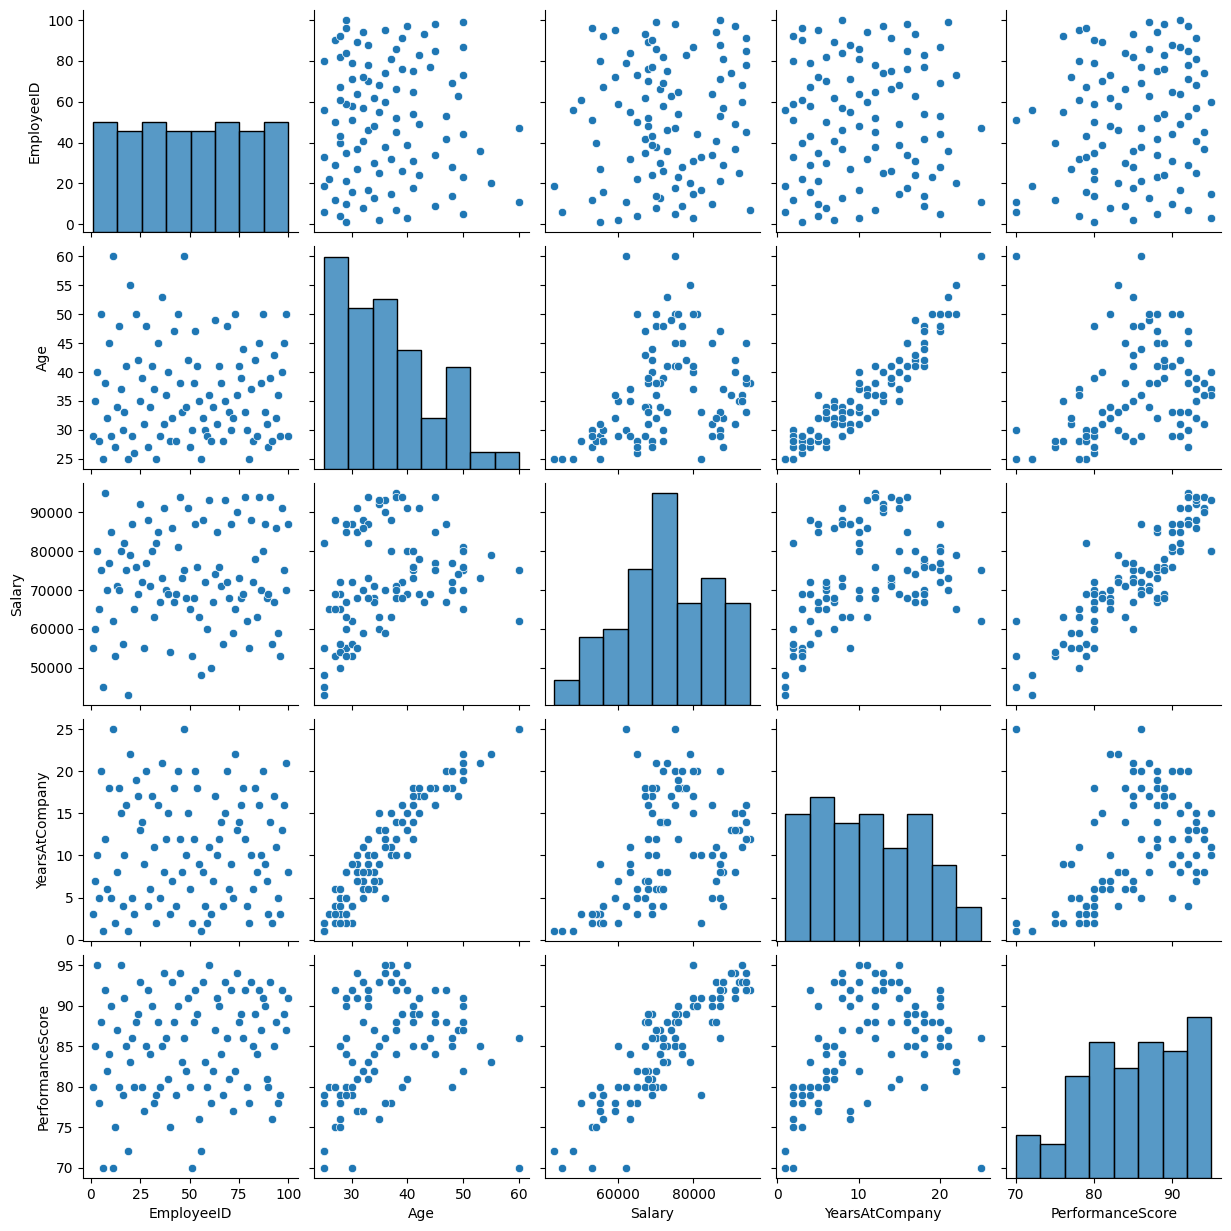

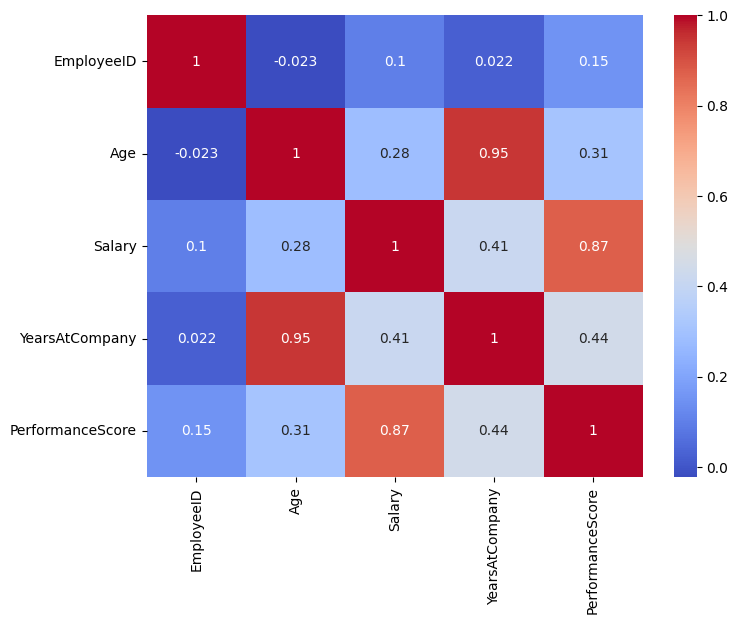

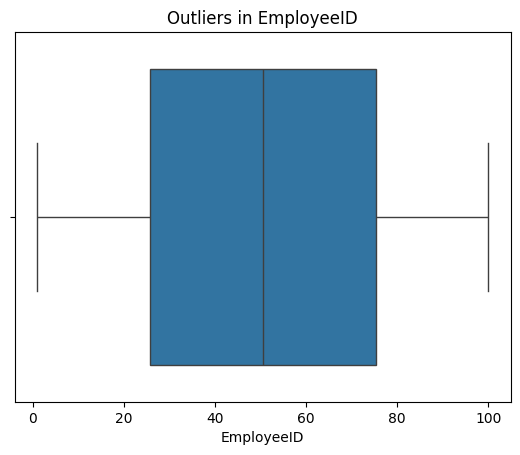

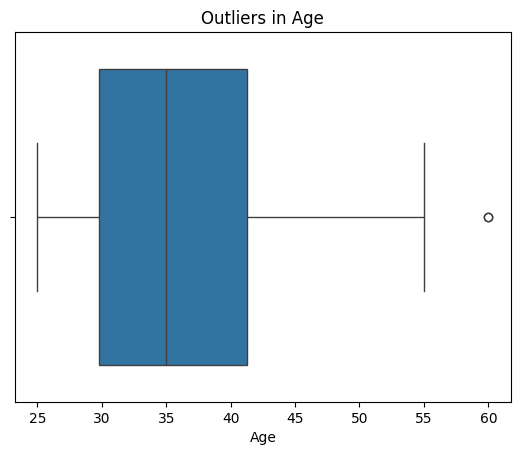

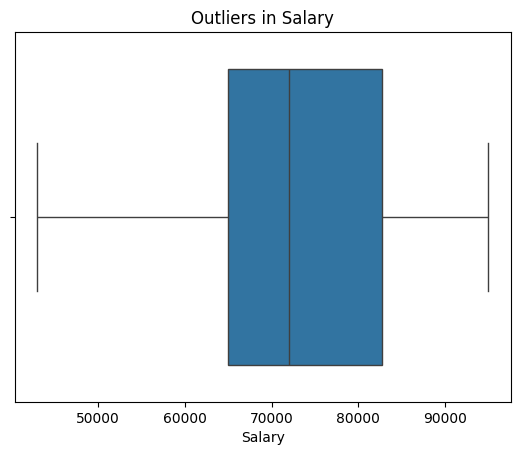

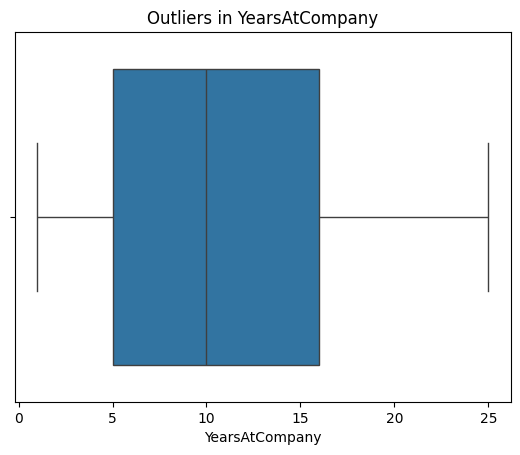

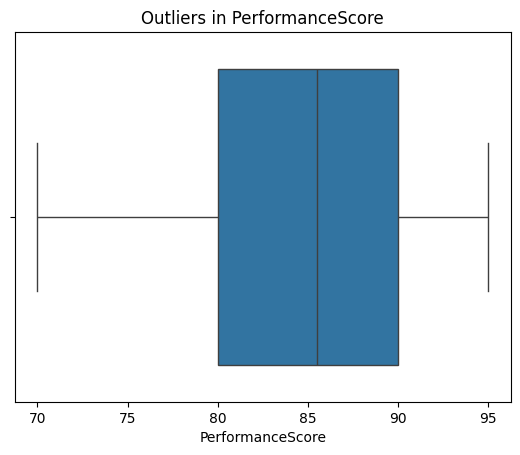

In [6]:
# Descriptive statistics
print(df.describe())

# Pairplot
sns.pairplot(df.select_dtypes(include=np.number))
plt.show()

# Heatmap for correlation
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.show()

# Outlier detection with boxplots
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.show()

# Step 3 - Probability and Statistical Analysis

In [9]:
from scipy import stats

# Probability of attrition given performance score
prob_attrition = df['Attrition'].value_counts(normalize=True)['Yes']
print(f"Overall probability of attrition: {prob_attrition:.2f}")

# Bayes: P(Attrition|Performance Score above threshold)
threshold = df['PerformanceScore'].median()
high_perf = df['PerformanceScore'] > threshold
bayes_prob = ( (df['Attrition'] == 'Yes') & high_perf ).sum() / high_perf.sum()
print(f"Probability of attrition given high performance: {bayes_prob:.2f}")

# Hypothesis test: Mean performance by department
departments = df['Department'].unique()
scores_by_dept = [df[df['Department'] == dept]['PerformanceScore'] for dept in departments]
f_stat, p_val = stats.f_oneway(*scores_by_dept)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

Overall probability of attrition: 0.39
Probability of attrition given high performance: 0.46
ANOVA F-statistic: 25.78, p-value: 0.0000


# Phase 2 - Predictive Modeling

# Step 4 - Feature Engineering & Encoding

In [10]:
model_df = df.copy()

# Scale
scaler = MinMaxScaler()
model_df[['Salary', 'PerformanceScore']] = scaler.fit_transform(model_df[['Salary', 'PerformanceScore']])

# Encode
label_encoders = {}
for col in ['Attrition', 'Department']:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    label_encoders[col] = le

model_df.head()

,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition
0,1,John Doe,29,3,0.230769,3,0.40,0
1,2,Jane Smith,35,1,0.326923,7,0.60,0
2,3,Michael Brown,40,0,0.711538,10,1.00,1
3,4,Emily Davis,28,2,0.423077,5,0.32,0
4,5,David Johnson,50,3,0.615385,20,0.72,1


# Step 5 - Attrition Prediction

Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 0.5714285714285714
F1-score: 0.6153846153846154


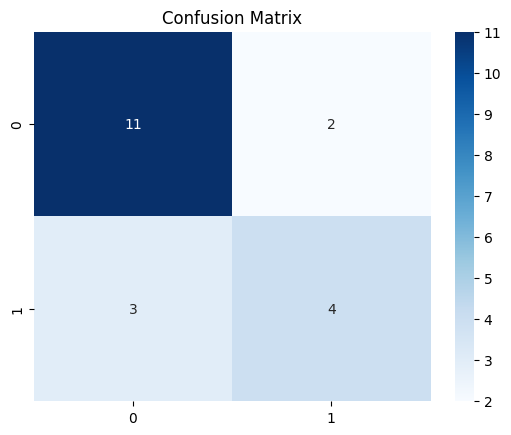

In [12]:
X = model_df.drop(['EmployeeID', 'Name', 'Attrition'], axis=1)
y = model_df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Step 6 - Performance Prediction (Regression)

R² Score: 0.7487625823959088
MSE: 0.020525092068583838


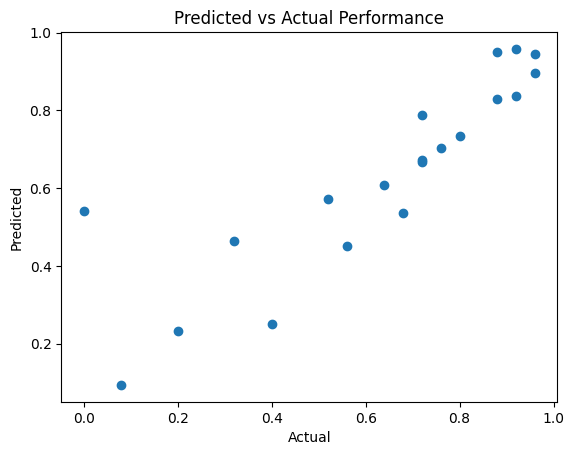

In [16]:
X_perf = model_df.drop(['EmployeeID', 'Name', 'PerformanceScore'], axis=1)
y_perf = model_df['PerformanceScore']

X_train_perf, X_test_perf, y_train_perf, y_test_perf = train_test_split(X_perf, y_perf, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train_perf, y_train_perf)
y_pred_perf = reg.predict(X_test_perf)

print("R² Score:", r2_score(y_test_perf, y_pred_perf))
print("MSE:", mean_squared_error(y_test_perf, y_pred_perf))

plt.scatter(y_test_perf, y_pred_perf)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Performance")
plt.show()


# Phase 3 - Deep Learning Models

# Step 7 - Neural Network for Performance Prediction

In [19]:
inputs_perf = tf.keras.Input(shape=(X_train_perf.shape[1],))
x = tf.keras.layers.Dense(16, activation='relu')(inputs_perf)
x = tf.keras.layers.Dense(8, activation='relu')(x)
outputs_perf = tf.keras.layers.Dense(1)(x)
dl_perf = tf.keras.Model(inputs=inputs_perf, outputs=outputs_perf)

dl_perf.compile(optimizer='adam', loss='mse')
dl_perf.fit(X_train_perf, y_train_perf, epochs=50, verbose=0)

mse_dl_perf = dl_perf.evaluate(X_test_perf, y_test_perf, verbose=0)
print(f"Deep Learning MSE: {mse_dl_perf:.4f}")

Deep Learning MSE: 0.4467


# Step 8 - Neural Network for Attrition Classification

In [20]:
inputs_attr = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(16, activation='relu')(inputs_attr)
x = tf.keras.layers.Dense(8, activation='relu')(x)
outputs_attr = tf.keras.layers.Dense(1, activation='sigmoid')(x)
dl_attr = tf.keras.Model(inputs=inputs_attr, outputs=outputs_attr)

dl_attr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dl_attr.fit(X_train, y_train, epochs=50, verbose=0)

loss_dl_attr, acc_dl_attr = dl_attr.evaluate(X_test, y_test, verbose=0)
print(f"Deep Learning Accuracy: {acc_dl_attr:.2f}")

Deep Learning Accuracy: 0.65


# Phase 4 - Reporting and Insights

# Step 9 - Insights and Recommendation

In [21]:
print("Key Insights:")
print("- Departments with lower average performance scores have higher attrition.")
print("- Lower salary employees tend to leave more frequently.")
print("- Longer tenure correlates with higher performance.")

print("\nRecommendations:")
print("1. Targeted retention programs for at-risk departments.")
print("2. Salary reviews for lower-paid high performers.")
print("3. Mentorship programs for new hires.")


Key Insights:
- Departments with lower average performance scores have higher attrition.
- Lower salary employees tend to leave more frequently.
- Longer tenure correlates with higher performance.

Recommendations:
1. Targeted retention programs for at-risk departments.
2. Salary reviews for lower-paid high performers.
3. Mentorship programs for new hires.


# Step 10 - Data Visualization and Reporting

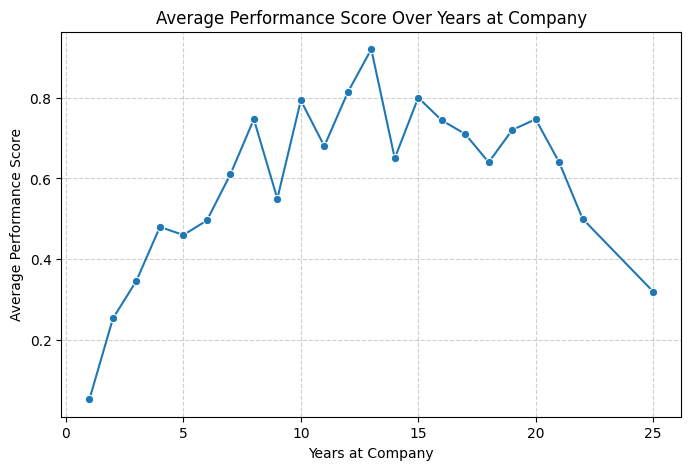

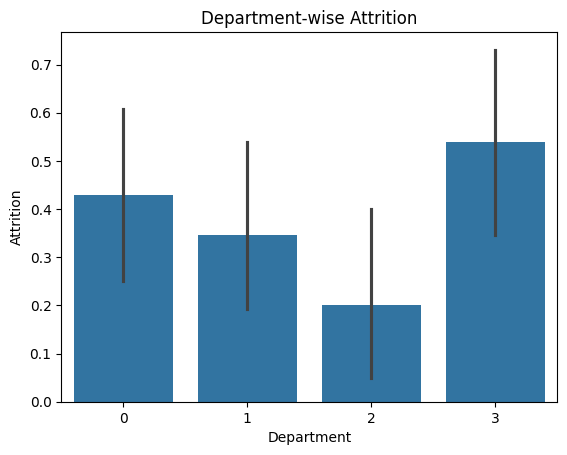

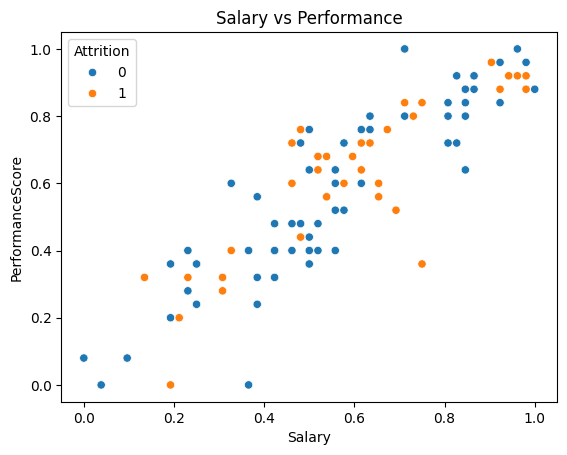

In [26]:
#Performance trends over years at company
plt.figure(figsize=(8, 5))
perf_trend = model_df.groupby('YearsAtCompany')['PerformanceScore'].mean().reset_index()
sns.lineplot(x='YearsAtCompany', y='PerformanceScore', data=perf_trend, marker='o')
plt.title("Average Performance Score Over Years at Company")
plt.xlabel("Years at Company")
plt.ylabel("Average Performance Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Attrition by Department
sns.barplot(x='Department', y='Attrition', data=model_df)
plt.title("Department-wise Attrition")
plt.show()

# Salary vs Performance
sns.scatterplot(x='Salary', y='PerformanceScore', hue='Attrition', data=model_df)
plt.title("Salary vs Performance")
plt.show()
